# Importing Libraries and Git.

In [1]:

#!git clone https://github.com/marco-siino/EEG-ATCNet.git
%pip install mne
%pip install PyWavelets

import os
import sys
import shutil
import time
import pywt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
os.chdir("/home/giuseppe_bonomo/DATASET/BCI2a_IV")

import models
from preprocess import get_data
# from keras.utils.vis_utils import plot_model

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2025-05-30 15:00:28.336282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 15:00:28.347402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748610028.359459 2313277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748610028.362985 2313277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748610028.371857 2313277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Organize the dataset.

In [2]:
# Creare la cartella "dataset" e "results" se non esistono già
os.makedirs("dataset", exist_ok=True)

# Creare le cartelle da s1 a s9
for i in range(1, 10):
    os.makedirs(f"dataset/s{i}", exist_ok=True)

In [3]:
"""# Download the dataset.
base_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"
save_path = "dataset/"

for i in range(1, 10):  # Da A01 a A09
    for suffix in ["T", "E"]:  # T per training, E per evaluation
        filename = f"A{i:02d}{suffix}.mat"
        url = base_url + filename
        os.system(f"wget -O {save_path}s{i}/{filename} {url}")"""

'# Download the dataset.\nbase_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"\nsave_path = "dataset/"\n\nfor i in range(1, 10):  # Da A01 a A09\n    for suffix in ["T", "E"]:  # T per training, E per evaluation\n        filename = f"A{i:02d}{suffix}.mat"\n        url = base_url + filename\n        os.system(f"wget -O {save_path}s{i}/{filename} {url}")'

# Functions definitions

In [4]:
#%%
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

## Preprocessing functions

## DB4 (Soft -> Threshold 5.5)

In [5]:
import numpy as np
import pywt

def db4_soft(signals, wavelet='db4', level=4, threshold=5.5):
    """
    Drop‐in replacement per il tuo preprocessing:
    – Accetta in ingresso un array di shape (N,1,3,750) o (1,3,750)
    – Applica DWT + hard‐threshold per canale
    – Restituisce un array della stessa shape, senza ricostruzione nel tempo,
      ma con i coefficienti sogliati "ripiegati" a 750 campioni.
    """
    arr = np.asarray(signals)
    # --- caso batch: (N,1,3,750) ---
    if arr.ndim == 4:
        N = arr.shape[0]
        out = [db4_soft(arr[i], wavelet, level, threshold) for i in range(N)]
        return np.stack(out, axis=0)

    # a questo punto arr.ndim == 3 → (1,3,750) o (3,750)
    # estraggo la parte (3,750)
    if arr.shape[0] == 1:
        sig3 = arr[0]   # (3,750)
    else:
        sig3 = arr      # (3,750)

    # Processing canale‐wise
    out_ch = []
    for ch in range(sig3.shape[0]):
        coeffs = pywt.wavedec(sig3[ch], wavelet, mode='per', level=level)
        # hard‐threshold
        coeffs_thr = [coeffs[0]]
        for d in coeffs[1:]:
            coeffs_thr.append(np.where(np.abs(d) < threshold, 0, d))
        # flatten + truncate/pad a 750
        feats1d = np.concatenate([c.ravel() for c in coeffs_thr])
        L = sig3.shape[-1]
        if feats1d.size >= L:
            feats1d = feats1d[:L]
        else:
            feats1d = np.pad(feats1d, (0, L - feats1d.size), 'constant')
        out_ch.append(feats1d)

    # ricompongo shape (1,3,750)
    processed = np.stack(out_ch, axis=0)[np.newaxis, ...]
    return processed


## DB4 (Hard -> Threshold 10.5)

In [6]:
def db4_hard(signal, wavelet='db4', level=4, threshold=10.5):
    """
    Drop‐in replacement per il tuo preprocessing:
    – Accetta in ingresso un array di shape (N,1,3,750) o (1,3,750)
    – Applica DWT + hard‐threshold per canale
    – Restituisce un array della stessa shape, senza ricostruzione nel tempo,
      ma con i coefficienti sogliati "ripiegati" a 750 campioni.
    """
    arr = np.asarray(signal)
    # --- caso batch: (N,1,3,750) ---
    if arr.ndim == 4:
        N = arr.shape[0]
        out = [db4_soft(arr[i], wavelet, level, threshold) for i in range(N)]
        return np.stack(out, axis=0)

    # a questo punto arr.ndim == 3 → (1,3,750) o (3,750)
    # estraggo la parte (3,750)
    if arr.shape[0] == 1:
        sig3 = arr[0]   # (3,750)
    else:
        sig3 = arr      # (3,750)

    # Processing canale‐wise
    out_ch = []
    for ch in range(sig3.shape[0]):
        coeffs = pywt.wavedec(sig3[ch], wavelet, mode='per', level=level)
        # hard‐threshold
        coeffs_thr = [coeffs[0]]
        for d in coeffs[1:]:
            coeffs_thr.append(np.where(np.abs(d) < threshold, 0, d))
        # flatten + truncate/pad a 750
        feats1d = np.concatenate([c.ravel() for c in coeffs_thr])
        L = sig3.shape[-1]
        if feats1d.size >= L:
            feats1d = feats1d[:L]
        else:
            feats1d = np.pad(feats1d, (0, L - feats1d.size), 'constant')
        out_ch.append(feats1d)

    # ricompongo shape (1,3,750)
    processed = np.stack(out_ch, axis=0)[np.newaxis, ...]
    return processed


## RDWT

In [7]:
import numpy as np
import pywt
from scipy import signal

def rational_dilated_wavelet_transform(sig, wavelet='db4', levels=4, dilation_factors=None):
    """
    Applica la Rational Dilated Wavelet Transform (RDWT) a un segnale EEG multidimensionale,
    senza applicare soglie ai coefficienti.

    Args:
        sig: array numpy di forma (eventi, 1, canali, campioni)
        wavelet: tipo di wavelet da utilizzare (default 'db4')
        levels: numero di livelli di decomposizione (default 4)
        dilation_factors: lista di fattori di dilatazione razionale (default: [3/2, 5/3, 7/4, ...])

    Returns:
        Segnale ricostruito con la RDWT (stessa dimensione dell'input)
    """
    eventi, _, canali, campioni = sig.shape
    print("Lunghezza originale del segnale:", sig.shape)

    if dilation_factors is None:
        dilation_factors = [3/2, 5/3, 7/4, 9/5]

    coeffs_approx = sig.copy()  # Inizializza con il segnale originale
    detail_coeffs = []

    for i in range(levels):
        factor = dilation_factors[i]
        wavelet_filter = pywt.Wavelet(wavelet)
        lo_d, hi_d = wavelet_filter.dec_lo, wavelet_filter.dec_hi

        # Ridimensionamento dei filtri con dilatazione razionale
        lo_d = signal.resample(lo_d, int(len(lo_d) * factor))
        hi_d = signal.resample(hi_d, int(len(hi_d) * factor))

        print(f"Livello {i+1}: coeffs_approx shape {coeffs_approx.shape}, lo_d shape {lo_d.shape}, hi_d shape {hi_d.shape}")

        approx = np.zeros_like(coeffs_approx)
        detail = np.zeros_like(coeffs_approx)

        # Applica la convoluzione per ogni canale EEG
        for e in range(eventi):
            for c in range(canali):
                approx[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], lo_d, mode='same')
                detail[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], hi_d, mode='same')

        detail_coeffs.append(detail)
        coeffs_approx = approx  # Passa l'approssimazione al livello successivo

    # Ricostruzione del segnale
    reconstructed = coeffs_approx.copy()
    for i in range(levels-1, -1, -1):
        reconstructed += detail_coeffs[i]

    print("Lunghezza del segnale ricostruito:", reconstructed.shape)
    return reconstructed

## STFT

In [8]:
import numpy as np
from scipy.signal import stft

def apply_stft(data, fs=256, nperseg=64, noverlap=32, nfft=128, threshold=0.1):
    """
    Drop-in STFT: restituisce modulo sogliato “ripiegato” a (E,1,C,N).

    Args:
      - data: (E,1,C,N)
    Returns:
      - out: (E,1,C,N)
    """
    arr = np.asarray(data)
    E, _, C, N = arr.shape
    out = np.zeros_like(arr)
    for e in range(E):
        for c in range(C):
            x = arr[e,0,c,:]
            f, t, Z = stft(x, fs=fs, nperseg=nperseg,
                           noverlap=noverlap, nfft=nfft)
            mag = np.abs(Z)
            mag[mag < threshold] = 0
            feats = mag.ravel()
            # slice/pad a N
            if feats.size >= N:
                feats1d = feats[:N]
            else:
                feats1d = np.pad(feats, (0, N - feats.size), 'constant')
            out[e,0,c,:] = feats1d
    return out


## Apply Preprocessing

In [9]:
def apply_preprocessing (signals_data, preprocessing):
  if preprocessing=="none":
    return signals_data
  elif preprocessing=="db4_soft":
    return db4_soft(signals_data)
  elif preprocessing=="db4_hard":
    return db4_hard(signals_data)
  elif preprocessing=="rdwt":
    return rational_dilated_wavelet_transform(signals_data)
  elif preprocessing=="stft":
    return apply_stft(signals_data)


# Model training function

In [ ]:
#%% Training
def train(dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models RatioWaveNet.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log RatioWaveNet.txt", "w")

    # Get dataset parameters
    dataset = dataset_conf.get('name')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and validation data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)


        print("\n\nBefore preprocessing X_train shape is:"+str(X_train.shape))
        print("Before preprocessing X_val shape is:"+str(X_val.shape))
        
        X_train = apply_preprocessing(X_train, preprocessing=signal_preprocessing)
        X_val = apply_preprocessing(X_val, preprocessing=signal_preprocessing)
        
        print("\n\nAfter preprocessing X_train shape is:"+str(X_train.shape))
        print("After preprocessing X_val shape is:"+str(X_val.shape))


        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.weights.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=AdamW(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()


# Evaluation function

In [ ]:
#%% Evaluation
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log RatioWaveNet.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
    #Ripetuto
    #signal_preprocessing = dataset_conf.get('signal_preprocessing')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        X_test = apply_preprocessing(X_test, preprocessing=signal_preprocessing)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.weights.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()

# Model selection and setup

In [ ]:
#%%
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'RockNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.RockNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'RatioWaveNet'):
        model = models.RatioWaveNet(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetB'):
        model = models.RockNetB(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetC'):
        model = models.RockNetC(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetX'):
        model = models.RockNetX(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'transformer',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 3,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='gelu',
        )
    elif(model_name == 'RockNetY'):
        model = models.RockNetY(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetZ'):
        model = models.RockNetZ(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='relu',
        )
    elif(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

# Run the simulation

## Define the run function.

In [ ]:
#%%
def run(signal_preprocessing):
    # Define dataset parameters
    dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'

    if dataset == 'BCI2a':
        in_samples = 1125
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
        data_path = 'dataset/' #os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    elif dataset == 'HGD':
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
        data_path = os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
    elif dataset == 'CS2R':
        in_samples = 1125
        # in_samples = 576
        n_channels = 32
        n_sub = 18
        n_classes = 3
        # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']
        classes_labels = ['Fingers', 'Wrist','Elbow']
        # classes_labels = ['Fingers', 'Elbow']
        data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/resultsRatioWaveNet"
    if not  os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist

    # Set dataset paramters
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False,
                     'signal_preprocessing':signal_preprocessing}

    # Set training hyperparamters
    train_conf = { 'batch_size': 64, 'epochs': 1500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'RatioWaveNet'}

    # Train the model
    train(dataset_conf, train_conf, results_path)

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
    test(model, dataset_conf, results_path)


## RDWT


Training on subject  1


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

I0000 00:00:1748610031.815789 2313277 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 815 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:ac:00.0, compute capability: 8.9
I0000 00:00:1748610042.067840 2313491 service.cc:152] XLA service 0x7c33e4002ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748610042.067864 2313491 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-05-30 15:00:42.465199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748610044.369989 2313491 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-30 15:00:48.923817: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2025-05-30 15:05:23.956112: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 706.92MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Subject: 1   seed 1   time: 4.9 m   valid_acc: 0.8276   valid_loss: 0.565
Plot Learning Curves ....... 


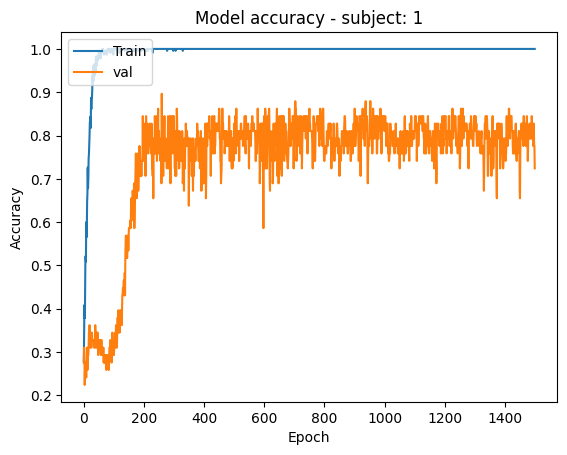

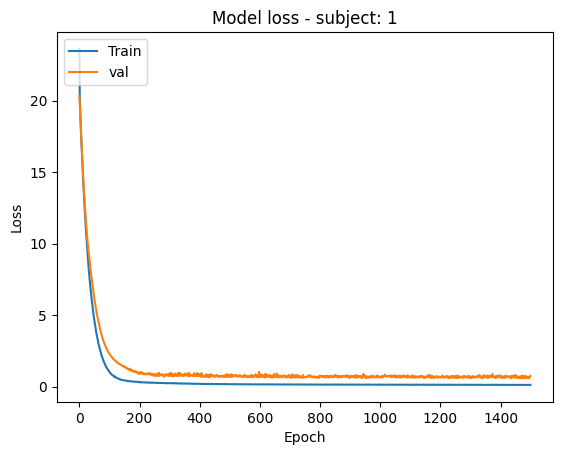


Training on subject  2


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

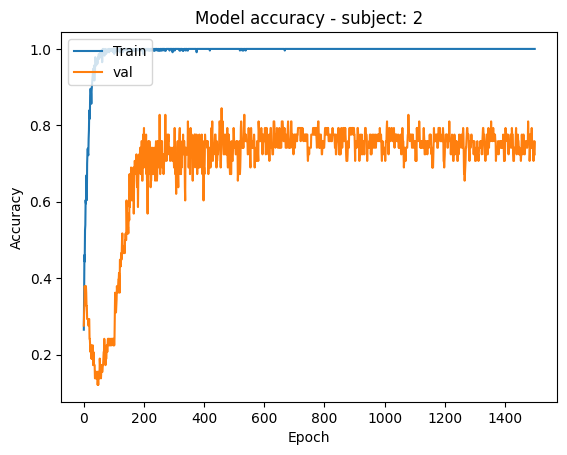

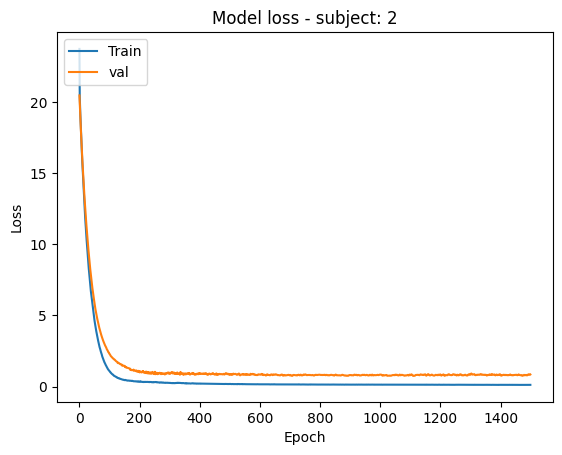


Training on subject  3


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

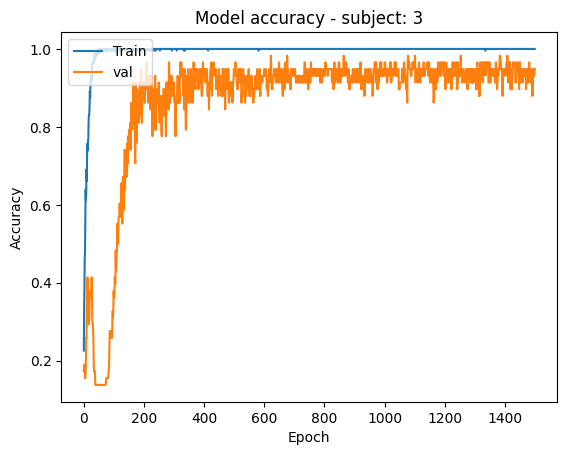

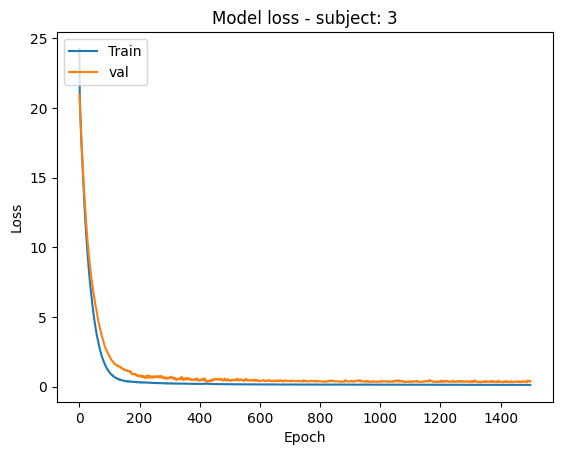


Training on subject  4


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

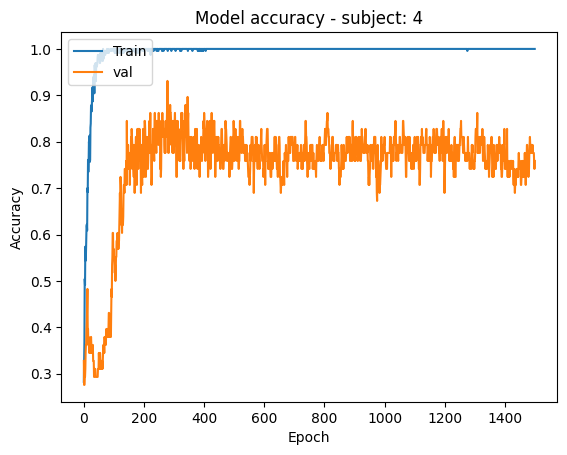

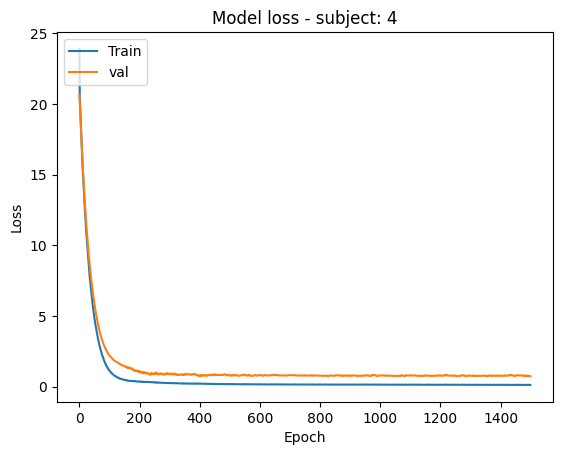


Training on subject  5


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

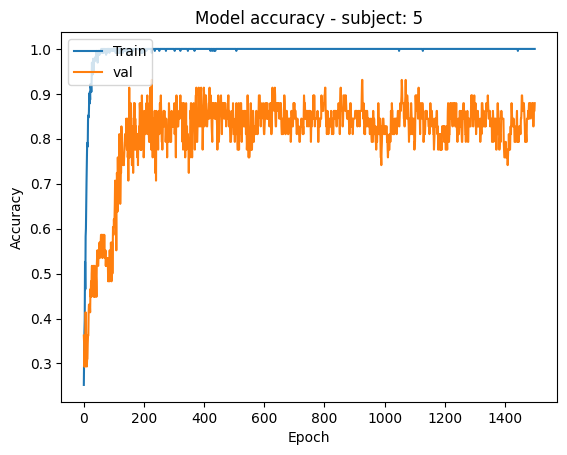

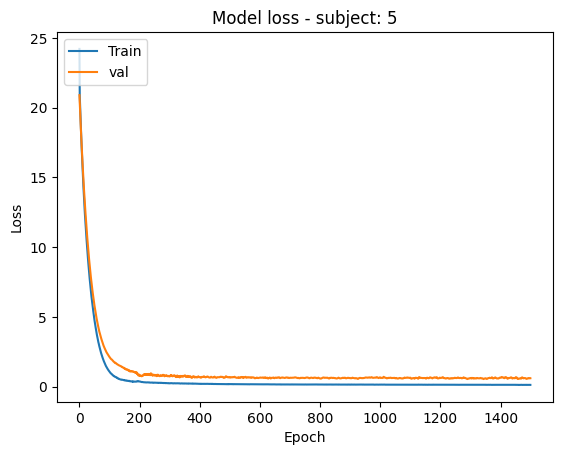


Training on subject  6


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

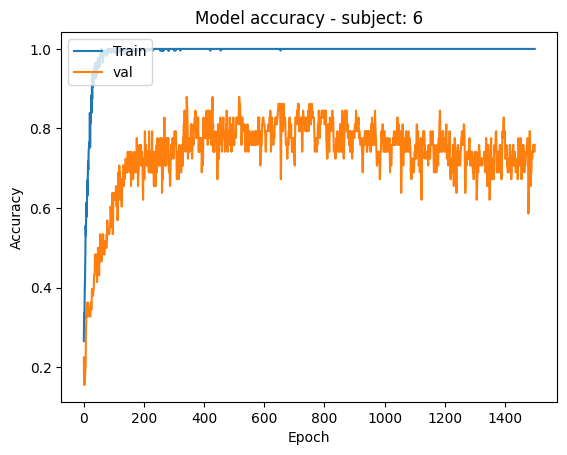

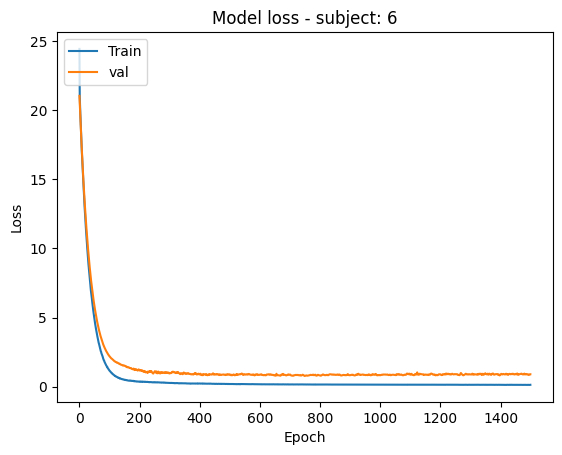


Training on subject  7


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

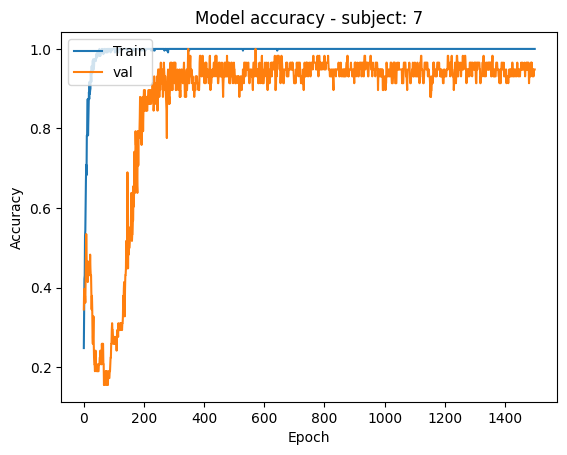

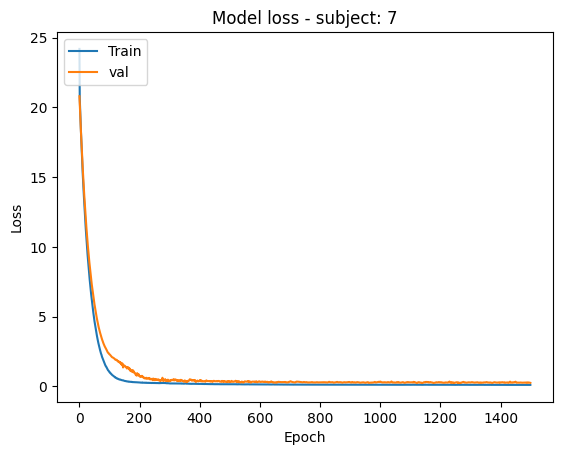


Training on subject  8


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

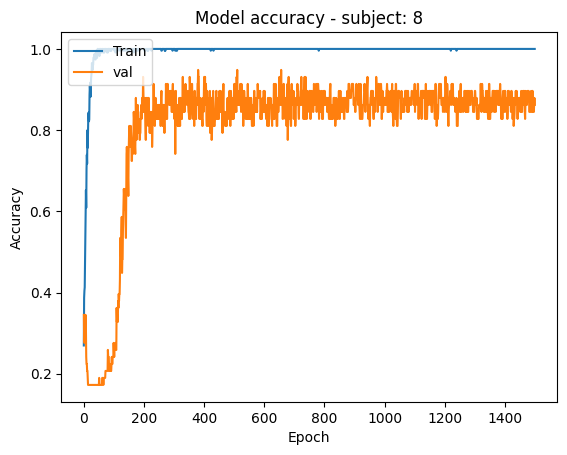

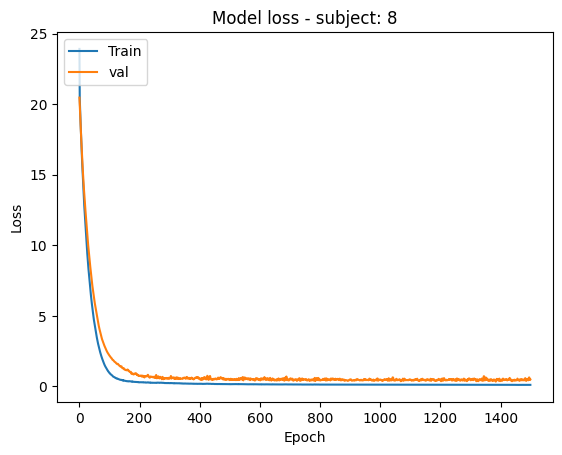


Training on subject  9


Before preprocessing X_train shape is:(230, 1, 22, 1125)
Before preprocessing X_val shape is:(58, 1, 22, 1125)
Lunghezza originale del segnale: (230, 1, 22, 1125)
Livello 1: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (230, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (230, 1, 22, 1125)
Lunghezza originale del segnale: (58, 1, 22, 1125)
Livello 1: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (58, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale 

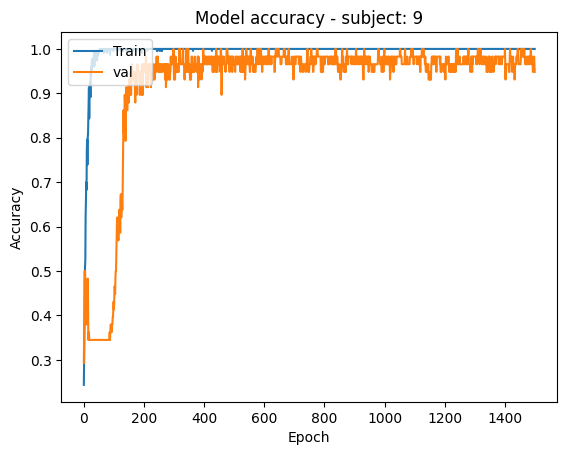

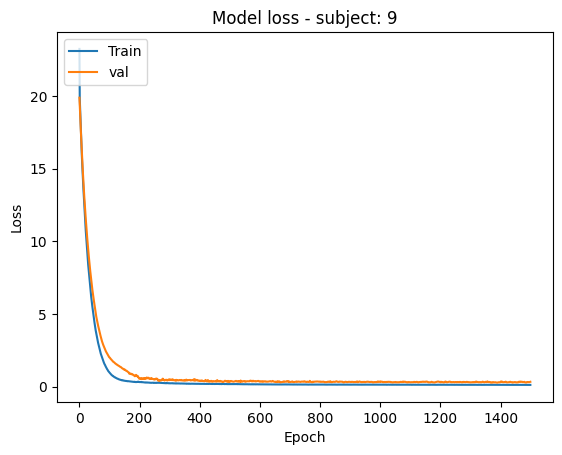


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  82.76   79.31   96.55   81.03   89.66   84.48   93.10   91.38   98.28     88.51   
---------------------------------
Average acc - all seeds: 88.51 %

Train Time  - all seeds: 43.9 min
---------------------------------

Lunghezza originale del segnale: (288, 1, 22, 1125)
Livello 1: coeffs_approx shape (288, 1, 22, 1125), lo_d shape (12,), hi_d shape (12,)
Livello 2: coeffs_approx shape (288, 1, 22, 1125), lo_d shape (13,), hi_d shape (13,)
Livello 3: coeffs_approx shape (288, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Livello 4: coeffs_approx shape (288, 1, 22, 1125), lo_d shape (14,), hi_d shape (14,)
Lunghezza del segnale ricostruito: (288, 1, 22, 1125)
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
L

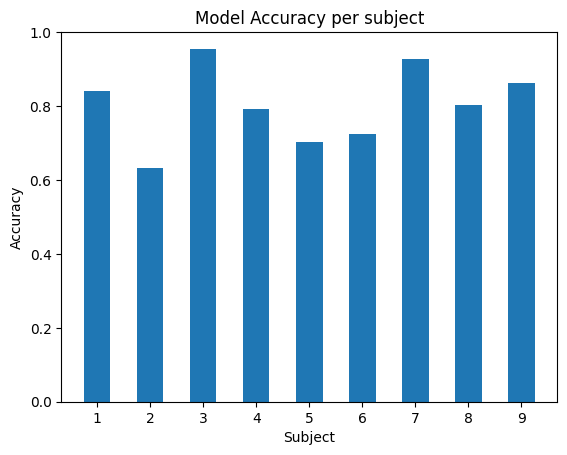

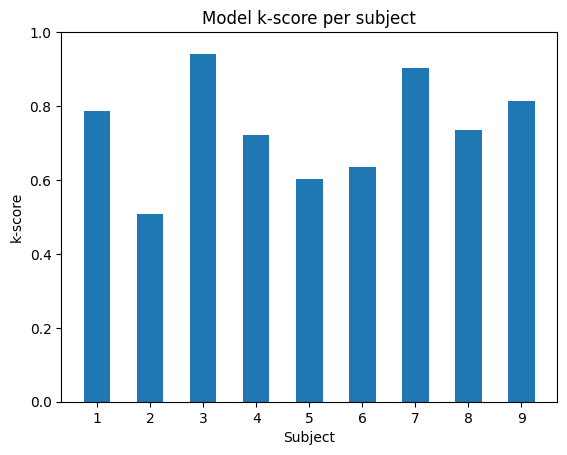

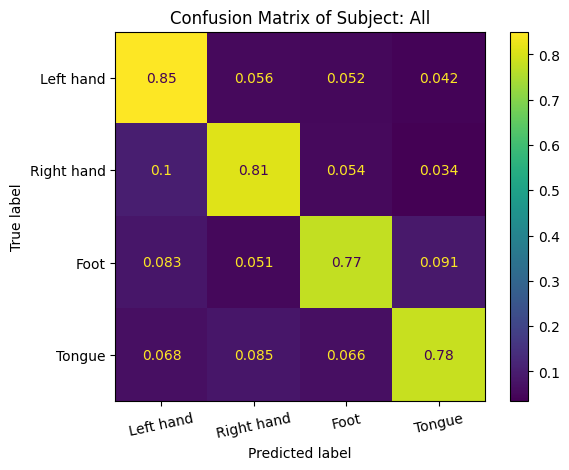

In [14]:
run("rdwt")